<a href="https://colab.research.google.com/github/jogong2718/COVID-19-Radiography-Models/blob/main/Github_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from tqdm import tqdm
import imageio as iio
import cv2 as cv
import pickle
from natsort import natsorted
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## stuff

In [ ]:
os.chdir('your data link')
os.listdir()

In [ ]:
with open('covid_image_and_mask_.pkl', 'rb') as handle:
    covid_everything = pickle.load(handle)

In [ ]:
with open('normal_image_and_mask_.pkl', 'rb') as handle:
    normal_everything = pickle.load(handle)

In [ ]:
with open('pneumonia_image_and_mask_.pkl', 'rb') as handle:
    pneumonia_everything = pickle.load(handle)

In [ ]:
print(len(covid_everything[0]), len(normal_everything[0]), len(pneumonia_everything[0]))

In [ ]:
covid_images, covid_masks = covid_everything
covid_images = covid_images.tolist()
covid_masks = covid_masks.tolist()

In [ ]:
normal_images, normal_masks = normal_everything
normal_images = normal_images.tolist()
normal_masks = normal_masks.tolist()

In [ ]:
pneumonia_images, pneumonia_masks = pneumonia_everything
pneumonia_images = pneumonia_images.tolist()
pneumonia_masks = pneumonia_masks.tolist()

In [ ]:
big_boi_images = covid_images+normal_images+pneumonia_images
big_boi_masks = covid_masks+normal_masks+pneumonia_masks

In [ ]:
big_boi_images = np.asarray(big_boi_images)
big_boi_masks = np.asarray(big_boi_masks)

In [ ]:
big_boi_images.shape

In [ ]:
big_boi_masks.shape

In [ ]:
plt.imshow(big_boi_images[2020], cmap = 'binary')

In [ ]:
plt.imshow(big_boi_masks[2020], cmap = 'binary')

In [ ]:
pic_train = big_boi_images/255.

In [ ]:
mask_test = big_boi_masks/255.

In [ ]:
pic_train.shape

In [ ]:
mask_test.shape

In [ ]:
with open('image_segementation_data_final_og.pkl', 'wb') as handle:
    pickle.dump((pic_train, mask_test), handle, protocol=pickle.HIGHEST_PROTOCOL)

## model

In [ ]:
os.chdir('your data link')
os.listdir()

In [ ]:
with open('image_segementation_data_final_og.pkl', 'rb') as handle:
    image_segementation_stuff = pickle.load(handle)

In [ ]:
pic_train = image_segementation_stuff[0]
mask_test = image_segementation_stuff[1]

In [ ]:
pic_train.shape

In [ ]:
def conv_block(input, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# main function
def build_unet(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)
    s5, p5 = encoder_block(p4, 512)

    b1 = conv_block(p5, 512)

    d0 = decoder_block(b1, s5, 512)
    d1 = decoder_block(d0, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = tf.keras.Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
input_shape = (128, 128, 1)
model = build_unet(input_shape)

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

In [ ]:
from keras import backend as K

# dice
def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator / denominator

# iou
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true,[1, 2, 3])+K.sum(y_pred,[1, 2, 3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [ ]:
# customized optimizer
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001, #0.00009
    decay_steps=10000,
    decay_rate=0.6)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=dice_loss,
    metrics=[iou_coef,'accuracy']
)

In [ ]:
# train
with tf.device('/device:GPU:0'):
    history = model.fit(
        x=pic_train, # X: the data the model use to learn
        y=mask_test.reshape((len(mask_test), 128, 128, 1)), # Y: the target the model try to predict
        
        ## Your Changes Start Here ##
        # there is a sweet spot, you don't want to overfit, but you also want to make sure your model learned something
        validation_split=0.2, # a ratio of percentage that the model uses for validating
        batch_size=70,
        epochs=200
        ## Your Changes Ends Here ##
    )

In [ ]:
print("best train loss: " + str(min(history.history['loss'])) + "\n" + "best train acc: " + str(max(history.history['accuracy'])))
print("best test loss: " + str(min(history.history['val_loss'])) + "\n" + "best test acc: " + str(max(history.history['val_accuracy'])))
print("best train iou: " + str(max(history.history['iou_coef'])) + "\n" + "best test iou: " + str(max(history.history['val_iou_coef'])))

In [ ]:
plt.figure(figsize=(28, 8))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss', 'val_loss',])
plt.subplot(1, 3, 2)
plt.plot(history.history['iou_coef'])
plt.plot(history.history['val_iou_coef'])
plt.legend(['train_iou_coef', 'val_iou_coef'])
plt.subplot(1, 3, 3)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

## Prediction


In [ ]:
os.chdir('your data link')
os.listdir()

In [ ]:
model.save('image_segementation_model.h5')

In [ ]:
pic_train_pred_ = model.predict(pic_train)
pic_train_pred_.shape

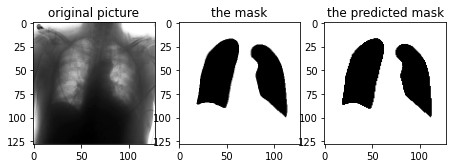

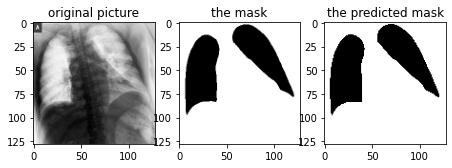

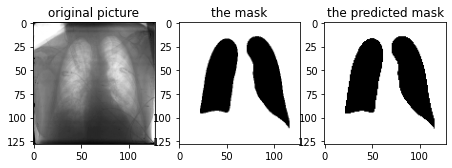

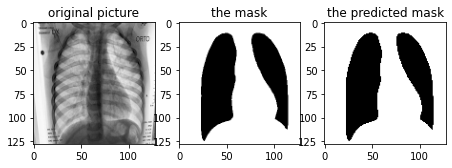

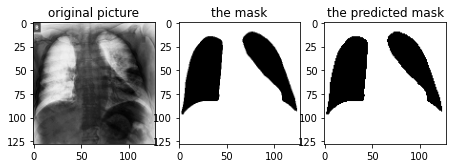

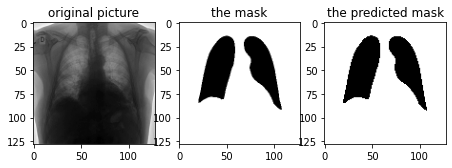

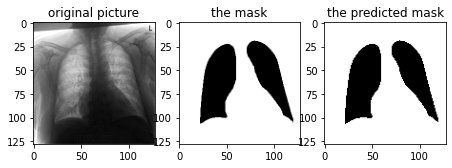

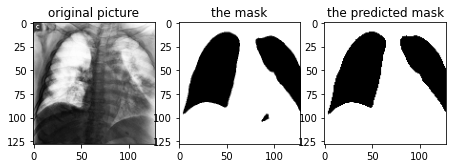

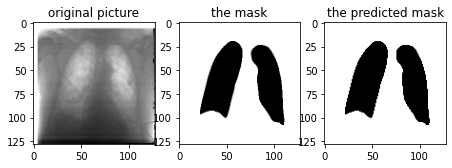

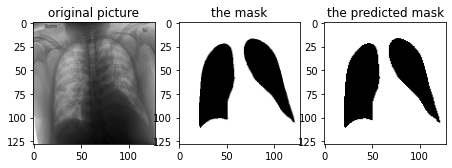

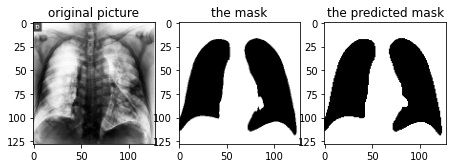

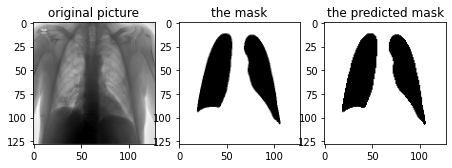

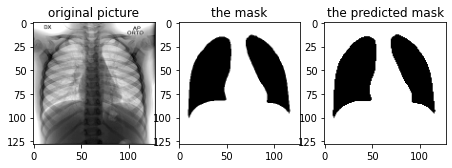

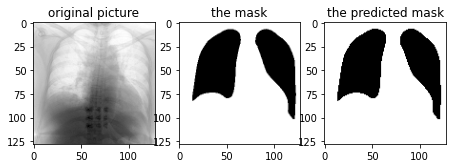

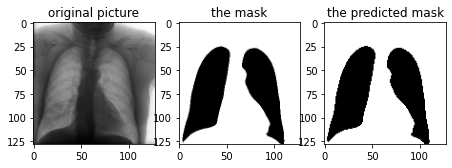

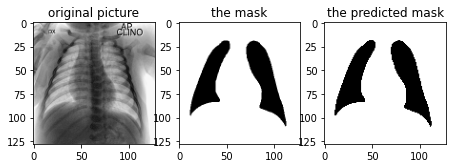

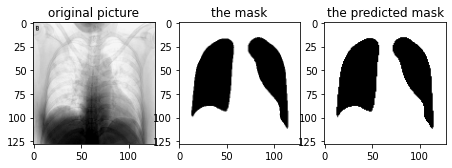

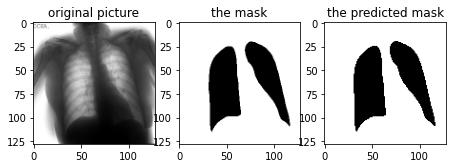

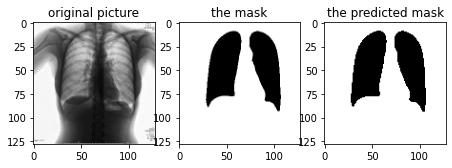

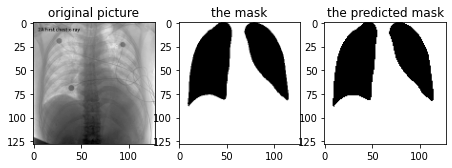

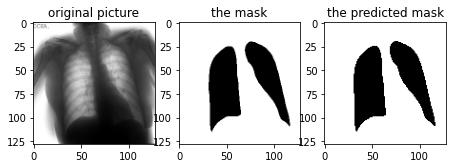

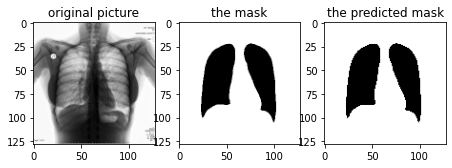

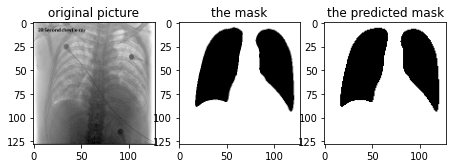

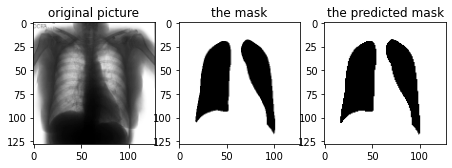

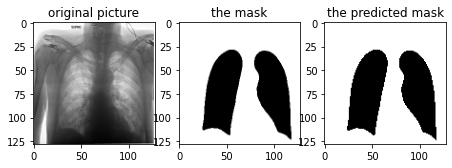

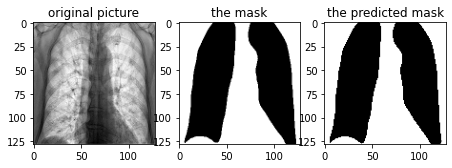

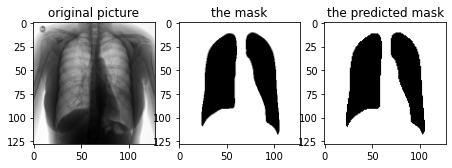

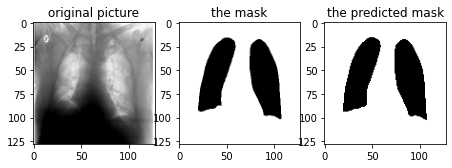

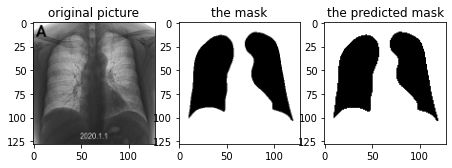

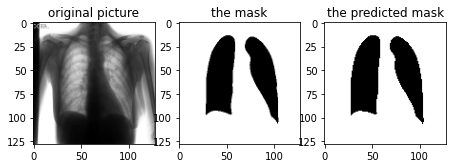

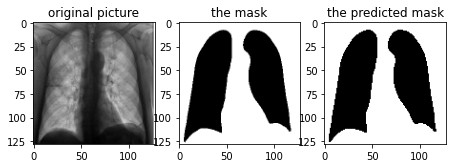

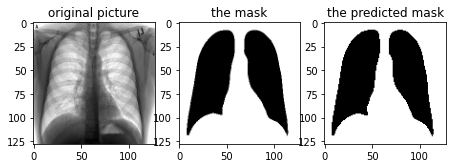

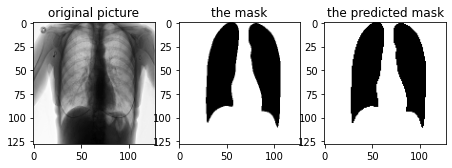

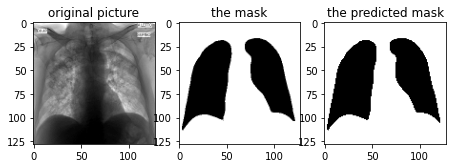

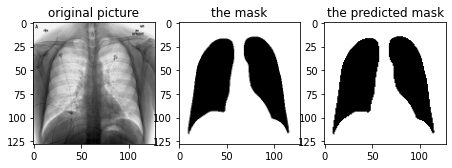

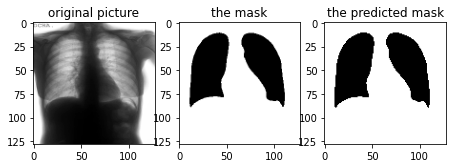

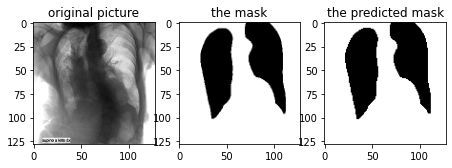

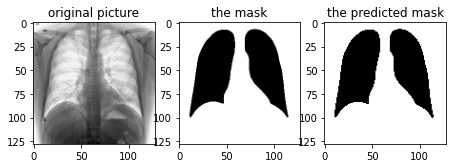

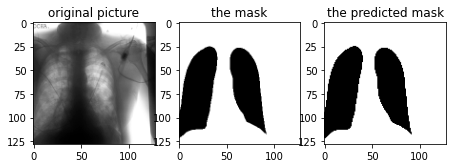

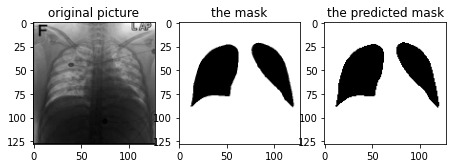

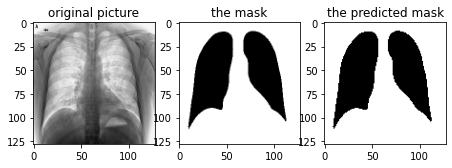

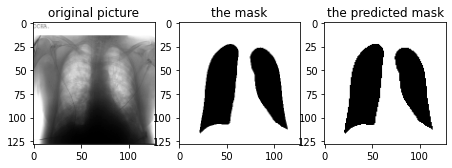

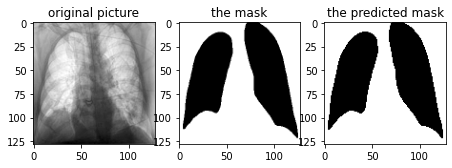

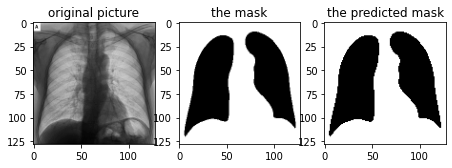

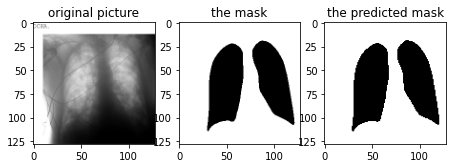

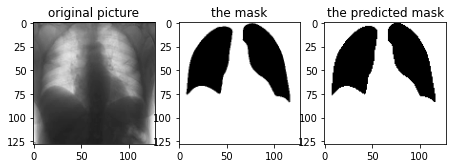

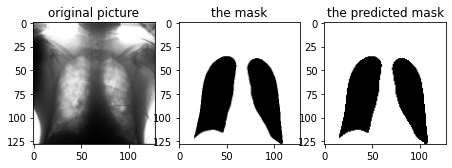

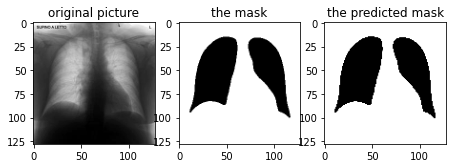

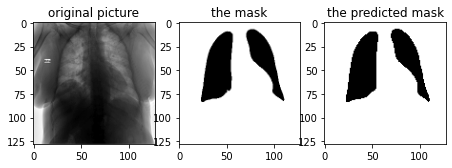

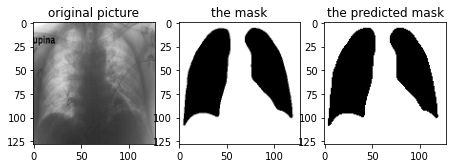

In [ ]:
for i in range(50):
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 4, 1)
    plt.imshow(pic_train[i], cmap = 'binary')
    plt.title('original picture')
    plt.subplot(1, 4, 2)
    plt.imshow(mask_test[i], cmap = 'binary')
    plt.title('the mask')
    plt.subplot(1, 4, 3)
    plt.imshow(pic_train_pred_[i].reshape((128, 128)), cmap = 'binary')
    plt.title('the predicted mask')
    plt.show()